In [1]:
# Import libraries
import numpy as np
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.ticker as ticker
from sklearn.cluster import KMeans

from japanmap import picture, pref_names

In [2]:
input_path = "../data/processed/housing_market_japan.csv"
df = pd.read_csv(input_path, encoding="utf-8")

In [3]:
english_to_japanese_pref = {
    "Hokkaido": "北海道",
    "Aomori": "青森県",
    "Iwate": "岩手県",
    "Miyagi": "宮城県",
    "Akita": "秋田県",
    "Yamagata": "山形県",
    "Fukushima": "福島県",
    "Ibaraki": "茨城県",
    "Tochigi": "栃木県",
    "Gunma": "群馬県",
    "Saitama": "埼玉県",
    "Chiba": "千葉県",
    "Tokyo": "東京都",
    "Kanagawa": "神奈川県",
    "Niigata": "新潟県",
    "Toyama": "富山県",
    "Ishikawa": "石川県",
    "Fukui": "福井県",
    "Yamanashi": "山梨県",
    "Nagano": "長野県",
    "Gifu": "岐阜県",
    "Shizuoka": "静岡県",
    "Aichi": "愛知県",
    "Mie": "三重県",
    "Shiga": "滋賀県",
    "Kyoto": "京都府",
    "Osaka": "大阪府",
    "Hyogo": "兵庫県",
    "Nara": "奈良県",
    "Wakayama": "和歌山県",
    "Tottori": "鳥取県",
    "Shimane": "島根県",
    "Okayama": "岡山県",
    "Hiroshima": "広島県",
    "Yamaguchi": "山口県",
    "Tokushima": "徳島県",
    "Kagawa": "香川県",
    "Ehime": "愛媛県",
    "Kochi": "高知県",
    "Fukuoka": "福岡県",
    "Saga": "佐賀県",
    "Nagasaki": "長崎県",
    "Kumamoto": "熊本県",
    "Oita": "大分県",
    "Miyazaki": "宮崎県",
    "Kagoshima": "鹿児島県",
    "Okinawa": "沖縄県"
}

# Mapping: Japanese prefecture names to japanmap code (0–47)
name_to_code = {name: code for code, name in enumerate(pref_names)}

# Convert values (e.g., count or mean) per English-prefecture-name into {pref_code: value}
def build_prefecture_value_dict(data: pd.Series) -> dict:
    """
    Convert a Series with English prefecture names into a dict of {japanmap_code: value}.

    Parameters:
        data (pd.Series): Index should be English-prefecture names, values can be count, mean, etc.

    Returns:
        dict: Mapping of japanmap prefecture code -> corresponding value.

    Example usage:
        # For average price per prefecture
        pref_mean = df.groupby("Prefecture")["Total transaction value"].mean()
        code_to_mean = build_prefecture_value_dict(pref_mean)

        # For number of records per prefecture
        pref_counts = df["Prefecture"].value_counts()
        code_to_count = build_prefecture_value_dict(pref_counts)
    """
    return {
        name_to_code[english_to_japanese_pref[pref]]: value
        for pref, value in data.items()
        if pref in english_to_japanese_pref and english_to_japanese_pref[pref] in name_to_code
    }


In [4]:
def plot_prefecture_colormap(pref_values, title="Prefecture Data Map", save_path=None, display=True):
    """
    Draws and optionally saves a choropleth map of Japan colored by values per prefecture.

    Parameters
    ----------
    pref_values : pandas.Series
        Series with prefecture names as index and numerical values (e.g., count, mean, median) as values.
    title : str, optional
        Title displayed at the top of the map.
    save_path : str or None, optional
        If a path is provided, the figure is saved to that location.
    display : bool, optional
        If True, the map will be shown in the notebook. Default is True.
    """
    import matplotlib.ticker as ticker

    # Define colormap and normalization based on the given values
    cmap = plt.get_cmap("Reds")
    norm = Normalize(vmin=0, vmax=pref_values.max())

    # Convert value to HEX color code using the colormap
    def value_to_hex(x):
        rgba = cmap(norm(x), bytes=True)[:3]
        return "#" + bytes(rgba).hex()

    # Create a mapping: prefecture name -> HEX color
    pref_color_hex = {pref: value_to_hex(val) for pref, val in pref_values.items()}

    # Convert prefecture names to codes and assign colors (external utility)
    code_to_color = build_prefecture_value_dict(pref_color_hex)

    # Generate the prefecture map image
    pic = picture(code_to_color)

    # Plot the image
    plt.figure(figsize=(8, 8))
    plt.imshow(pic)
    plt.axis("off")
    plt.title(title, fontsize=14)

    # Add colorbar manually (custom position and size)
    cbar_ax = plt.gcf().add_axes([0.88, 0.1, 0.03, 0.8])
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, cax=cbar_ax)
    cbar.formatter = ticker.FuncFormatter(lambda x, _: f"{int(x):,}")
    cbar.update_ticks()

    # Save and/or display
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    if display:
        plt.show()
    else:
        plt.close()


In [5]:
# Create a new data frame with the number of data, mean, and SE (standard error) for each prefecture
df_prefecture_stats = (
    df.groupby("Prefecture")["Total transaction value"]
    .agg(
        Count="size",
        Mean="mean",
        SE=lambda x: x.std(ddof=1) / np.sqrt(len(x))
    )
    .reset_index()
)

# Read the CSV file that contains housing stock data
df_housing_stock = pd.read_csv("../data/processed/prefecture_housing_stock.csv")

# Merge the two DataFrames on "Prefecture" (merge result directly into df_prefecture_stats)
df_prefecture_stats = pd.merge(
    df_prefecture_stats,
    df_housing_stock,
    on="Prefecture",
    how="left"
)

df_prefecture_stats.rename(columns={"Total": "Stock"}, inplace=True)

# Convert "Mean" to float
df_prefecture_stats["Mean"] = pd.to_numeric(
    df_prefecture_stats["Mean"], errors="coerce"
)

In [6]:
df_prefecture_stats

,Prefecture,Count,Mean,SE,Stock
0,Aichi,26132,3.654799e+07,129176.912634,3664700
1,Akita,3071,1.524119e+07,215789.284504,440600
2,Aomori,4103,1.507559e+07,182620.954187,590300
3,Chiba,31022,3.071016e+07,134655.239170,3191100
4,Ehime,3881,1.906264e+07,282198.363575,736800
5,Fukui,1921,1.775179e+07,326867.192397,341400
6,Fukuoka,17394,3.150018e+07,233550.265877,2703300
7,Fukushima,6256,2.026975e+07,173312.592882,862900
8,Gifu,6583,1.901875e+07,189945.367386,924100
9,Gunma,7236,1.881862e+07,153685.614212,967400


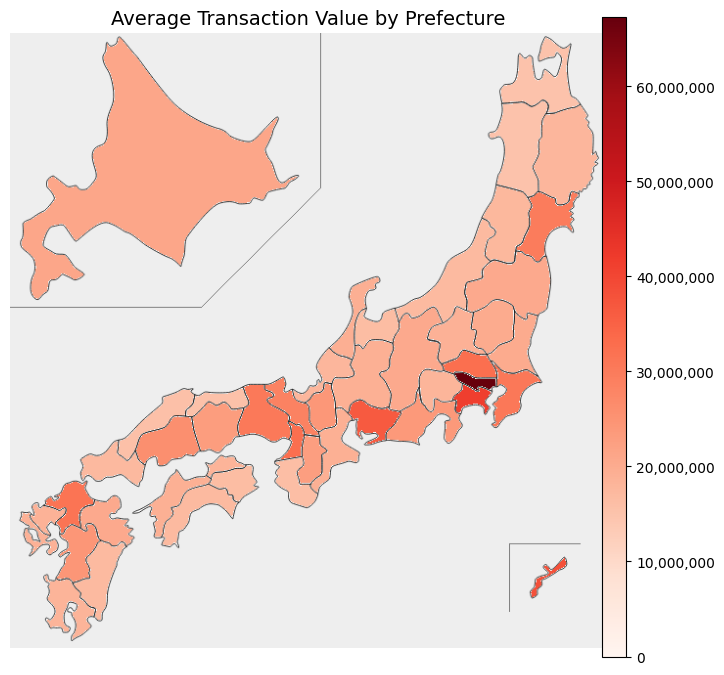

In [7]:
plot_prefecture_colormap(
    df_prefecture_stats.set_index("Prefecture")["Mean"],
    title="Average Transaction Value by Prefecture",
    save_path="../results/figures/pref_map_avg_price.png"
)

In [15]:
# 1. Compute the total housing stock across all prefectures
W = df_prefecture_stats["Stock"].sum()

# 2. Calculate the weighted mean (Ratio Estimation)
weighted_mean = (
    (df_prefecture_stats["Mean"] * df_prefecture_stats["Stock"]).sum() 
    / W
)

# 3. Calculate the variance of the weighted mean
variance = (
    (df_prefecture_stats["Stock"] ** 2) 
    * (df_prefecture_stats["SE"] ** 2)
).sum() / (W ** 2)

# 4. Standard error is the square root of the variance
std_error = np.sqrt(variance)

# 5. 95% confidence interval
ci_lower = weighted_mean - 1.96 * std_error
ci_upper = weighted_mean + 1.96 * std_error

# 6. Print or display the results
print("Weighted Mean (Method A):", weighted_mean)
print("Standard Error (Method A):", std_error)
print("95% CI (Method A): [{:.3f}, {:.3f}]".format(ci_lower, ci_upper))


Weighted Mean (Method A): 32079104.73195155
Standard Error (Method A): 51653.575027348095
95% CI (Method A): [31977863.725, 32180345.739]


In [19]:
# 1. Cluster the prefectures based on Mean price
K = 3  # choose the number of clusters

X = df_prefecture_stats[["Mean"]].values  # 1D (Mean) for clustering
kmeans = KMeans(n_clusters=K, random_state=11888757)
df_prefecture_stats["Cluster"] = kmeans.fit_predict(X)

# 2. Compute cluster-level stats
# Store results in a list of dicts, then convert to a DataFrame.
cluster_stats = []

for k in range(K):
    # 2.1: Identify which prefectures are in cluster k
    prefectures_in_cluster = df_prefecture_stats.loc[
        df_prefecture_stats["Cluster"] == k, "Prefecture"
    ]
    
    # 2.2: For cluster mean calculation, we do a weighted average
    # across prefectures in cluster k
    cluster_df = df_prefecture_stats[df_prefecture_stats["Cluster"] == k]
    W_k = cluster_df["Stock"].sum()
    if W_k == 0:
        # In case there's an edge case of zero Stock (unlikely), skip
        continue
    
    # Weighted cluster mean:
    cluster_mean_k = (
        (cluster_df["Mean"] * cluster_df["Stock"]).sum() 
        / W_k
    )
    
    # 2.3: Use the raw data from df (all transactions) for cluster's variance
    # Gather all rows whose Prefecture is in this cluster
    df_cluster_raw = df[df["Prefecture"].isin(prefectures_in_cluster)]
    
    # cluster sample size
    n_k = len(df_cluster_raw)
    if n_k <= 1:
        # Not enough data to compute variance
        sigma_k_sq = 0.0
    else:
        # sample variance of the transaction price
        sigma_k_sq = df_cluster_raw["Total transaction value"].var(ddof=1)
    
    # 2.4: Store the results for cluster k
    cluster_stats.append({
        "Cluster": k,
        "ClusterMean": cluster_mean_k,
        "W_k": W_k,
        "sigma_k_sq": sigma_k_sq,
        "n_k": n_k
    })

df_clusters = pd.DataFrame(cluster_stats)

# 3. Combine cluster means -> national mean
W_total = df_clusters["W_k"].sum()
numerator = (df_clusters["ClusterMean"] * df_clusters["W_k"]).sum()
mu_cluster = numerator / W_total  # final estimate

# 4. Compute standard error (Method B style)
# For each cluster, the variance of the cluster mean is (sigma_k_sq / n_k).
# Then we combine them via ratio formula:
# Var(mu_Cluster) = (1 / W_total^2) * sum( W_k^2 * (sigma_k_sq / n_k) )
df_clusters["Var_mean_k"] = df_clusters.apply(
    lambda row: row["sigma_k_sq"] / row["n_k"] if row["n_k"] > 0 else 0.0,
    axis=1
)

var_mu_cluster = (
    (df_clusters["W_k"] ** 2) * df_clusters["Var_mean_k"]
).sum() / (W_total ** 2)

se_mu_cluster = np.sqrt(var_mu_cluster)

# 95% CI
ci_lower = mu_cluster - 1.96 * se_mu_cluster
ci_upper = mu_cluster + 1.96 * se_mu_cluster

# 5. Print results
print("=== Cluster-Based Weighted Estimation (Method B) ===")
print(f"Number of Clusters: {K}")
print("\nCluster Details:")
print(df_clusters)

print("\nNational Estimate (Method B):")
print(f"Weighted Mean: {mu_cluster:.3f}")
print(f"Standard Error: {se_mu_cluster:.3f}")
print(f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")


=== Cluster-Based Weighted Estimation (Method B) ===
Number of Clusters: 3

Cluster Details:
   Cluster   ClusterMean       W_k    sigma_k_sq     n_k    Var_mean_k
0        0  1.962994e+07  26573500  2.902815e+14  188109  1.543156e+09
1        1  3.345566e+07  30272100  7.147120e+14  241100  2.964380e+09
2        2  6.733487e+07   8201400  5.040969e+15   46022  1.095339e+11

National Estimate (Method B):
Weighted Mean: 32079104.732
Standard Error: 51389.432
95% CI: [31978381.444, 32179828.019]


In [ ]:
best_result = None
min_se = float("inf")

for K in range(1, 11):
    # 1. Cluster the prefectures based on Mean price
    X = df_prefecture_stats[["Mean"]].values
    kmeans = KMeans(n_clusters=K, random_state=11888757, n_init="auto")
    df_prefecture_stats["Cluster"] = kmeans.fit_predict(X)

    # 2. Compute cluster-level stats
    cluster_stats = []
    for k in range(K):
        prefectures_in_cluster = df_prefecture_stats.loc[
            df_prefecture_stats["Cluster"] == k, "Prefecture"
        ]
        cluster_df = df_prefecture_stats[df_prefecture_stats["Cluster"] == k]
        W_k = cluster_df["Stock"].sum()
        if W_k == 0:
            continue
        cluster_mean_k = (
            (cluster_df["Mean"] * cluster_df["Stock"]).sum() / W_k
        )
        df_cluster_raw = df[df["Prefecture"].isin(prefectures_in_cluster)]
        n_k = len(df_cluster_raw)
        if n_k <= 1:
            sigma_k_sq = 0.0
        else:
            sigma_k_sq = df_cluster_raw["Total transaction value"].var(ddof=1)
        cluster_stats.append({
            "Cluster": k,
            "ClusterMean": cluster_mean_k,
            "W_k": W_k,
            "sigma_k_sq": sigma_k_sq,
            "n_k": n_k
        })

    df_clusters = pd.DataFrame(cluster_stats)

    # 3. Combine cluster means -> national mean
    W_total = df_clusters["W_k"].sum()
    numerator = (df_clusters["ClusterMean"] * df_clusters["W_k"]).sum()
    mu_cluster = numerator / W_total

    # 4. Compute standard error (Method B style)
    df_clusters["Var_mean_k"] = df_clusters.apply(
        lambda row: row["sigma_k_sq"] / row["n_k"] if row["n_k"] > 0 else 0.0,
        axis=1
    )
    var_mu_cluster = (
        (df_clusters["W_k"] ** 2) * df_clusters["Var_mean_k"]
    ).sum() / (W_total ** 2)
    se_mu_cluster = np.sqrt(var_mu_cluster)

    # 5. Save the best one
    if se_mu_cluster < min_se:
        min_se = se_mu_cluster
        best_result = {
            "K": K,
            "df_clusters": df_clusters.copy(),
            "mu_cluster": mu_cluster,
            "se_mu_cluster": se_mu_cluster,
            "ci_lower": mu_cluster - 1.96 * se_mu_cluster,
            "ci_upper": mu_cluster + 1.96 * se_mu_cluster
        }

# 6. Output best result
print("=== Cluster-Based Weighted Estimation (Method B) ===")
print(f"Number of Clusters: {best_result['K']}")
print("\nCluster Details:")
print(best_result["df_clusters"])

print("\nNational Estimate (Method B):")
print(f"Weighted Mean: {best_result['mu_cluster']:.3f}")
print(f"Standard Error: {best_result['se_mu_cluster']:.3f}")
print(f"95% CI: [{best_result['ci_lower']:.3f}, {best_result['ci_upper']:.3f}]")


=== Cluster-Based Weighted Estimation (Method B) ===
Number of Clusters: 2

Cluster Details:
   Cluster   ClusterMean       W_k    sigma_k_sq     n_k    Var_mean_k
0        0  1.995205e+07  28039000  2.982157e+14  198046  1.505790e+09
1        1  4.126713e+07  37008000  1.597765e+15  277185  5.764255e+09

National Estimate (Method B):
Weighted Mean: 32079104.732
Standard Error: 46321.218
95% CI: [31988315.144, 32169894.320]
